In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from data_generation import game_generation
from deepmctsmodel import DeepMctsModel

In [29]:
def training_loop(model: nn.Module, dataloader: DataLoader, optim: torch.optim.Optimizer, loss_fn: nn.Module, epochs: int = 100, device=torch.device('cpu')):
    losses = []

    model.to(device)
    model.train()

    for epoch in tqdm(range(epochs)):
        for X, y_truth, y_value in dataloader:
            epoch_losses = []
            epoch_accuracies = []
            X, y_truth, y_value = X.to(device), y_truth.to(device), torch.tensor(y_value, dtype=torch.float32, device=device)
            pred_value, pred_truth = model(X)
            loss: torch.Tensor = loss_fn(pred_value, pred_truth, y_value, y_truth, model.parameters())
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_losses.append(loss.item())
        losses.append(np.mean(epoch_losses))
    
    return losses

In [30]:
class Loss(nn.Module):
    def __init__(self, lambda_l2=1e-4) -> None:
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.lambda_l2 = lambda_l2
    
    def l2_loss(self, params):
        return self.lambda_l2 * sum(p.pow(2.0).sum() for p in params)
    
    def forward(self, pred_value: torch.Tensor, pred_truth, y_value, y_truth, params):      
        value_loss = self.mse_loss(pred_value, y_value)
        policy_loss = self.cross_entropy_loss(pred_truth.view(-1, 294), y_truth.view(-1, 294))
        l2 = self.l2_loss(params)
        
        loss = value_loss + policy_loss + l2
        return loss

In [31]:
class GameDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X, y_truth, y_value = self.data[idx]
        return X, y_truth, y_value

In [32]:
mcts_model = DeepMctsModel()
optim = torch.optim.SGD(mcts_model.parameters(), nesterov=True, lr=1e-4, dampening=0.0, momentum=0.9)
lambda_l2 = 1e-4
loss_fn = Loss(1e-4)
epochs = 100
batch_size = 32
shuffle = True
game_count = 6000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
games = game_generation(game_count)

Generating games: 100%|██████████| 6000/6000 [00:39<00:00, 153.22it/s]


In [34]:
dataset = GameDataset(games)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [35]:
X, y_truth, y_value = next(iter(dataloader))
pred_value, pred_truth = mcts_model(X)

In [36]:
losses = training_loop(mcts_model, dataloader, optim, loss_fn, epochs, device)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_76226/682021793.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y_truth, y_value = X.to(device), y_truth.to(device), torch.tensor(y_value, dtype=torch.float32, device=device)
/home/jgale/miniconda3/envs/my_push/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/jgale/miniconda3/envs/my_push/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect 

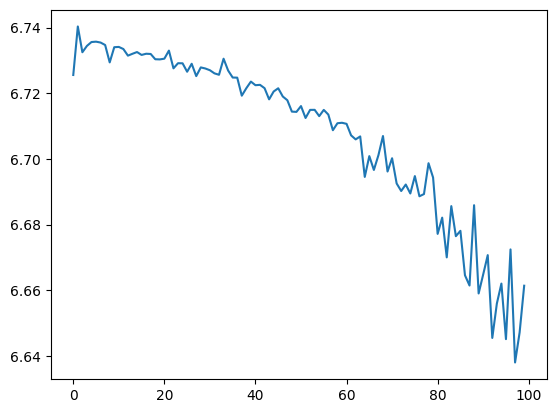

In [37]:
plt.plot(losses, label="Training Losses")
plt.show()

In [39]:
torch.save(mcts_model.state_dict(), f"./models/heuristic-trained-mcts-model-v0.pt")
torch.save(losses, "./models/heuristic-trained-mcts-model-v0-loss.array")